<a href="https://colab.research.google.com/github/SefiyeArican/Face-expression-recognition/blob/main/Face_expression_recognition_with_Deep_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Verisetimiz:**<br>
https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset/data

<br>**Referans alınan çalışmalar;**


*   https://www.kaggle.com/code/jonathanoheix/face-expression-recognition-with-deep-learning
*   https://github.com/rishabhjainps/Facial-Expression-Recognition




**Verisetine erişim**

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 94% 113M/121M [00:01<00:00, 98.2MB/s] 
100% 121M/121M [00:01<00:00, 94.7MB/s]


In [3]:
# The -q flag (-q or --quiet) allows the unzip command to run silently so that output such as the file list is not suppressed
!unzip -q face-expression-recognition-dataset.zip -d /content/
print("İşlem başarılı.")

İşlem başarılı.


**Veri yükleme ve inceleme**

In [4]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960

# Veri setini indirirken kullanmak için URL'yi doğrudan verebiliriz
DATA_SOURCE_URL = 'https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset/download'

# Colab'da Kaggle veri setlerini indirilecek klasör
KAGGLE_INPUT_PATH = '/content/kaggle/input'
KAGGLE_WORKING_PATH = '/content/kaggle/working'

# Klasörleri oluşturun
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Veriyi indirme işlemi
download_url = unquote(DATA_SOURCE_URL)
filename = urlparse(download_url).path.split('/')[-1]  # URL'den dosya adını çıkar
destination_path = os.path.join(KAGGLE_INPUT_PATH)

try:
    with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
        total_length = fileres.headers.get('content-length')
        if total_length is None:
            total_length = 0
        total_length = int(total_length)

        print(f'Dataset indiriliyor, {total_length} bayt sıkıştırılmış')
        dl = 0
        data = fileres.read(CHUNK_SIZE)
        while len(data) > 0:
            dl += len(data)
            tfile.write(data)
            if total_length > 0:  # total_length sıfır değilse kontrol et, sıfıra bölme hatasını önlemek için
                done = int(50 * dl / total_length)
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bayt indirildi")
                sys.stdout.flush()
            else:
                print("İndirme ilerlemesi belirlenemiyor. İndiriliyor...")  # İlerleme gösterilemiyorsa kullanıcıya bilgi ver
            data = fileres.read(CHUNK_SIZE)

        # Dosya uzantısına göre dosyayı çıkarma
        if filename.endswith('.zip'):
            with ZipFile(tfile.name) as zfile:
                zfile.extractall(destination_path)
        elif filename.endswith('.tar.gz') or filename.endswith('.tgz'):
            with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
        else:
            print(f'{filename} dosya formatı desteklenmiyor')

        print(f'\n{destination_path} konumuna indirildi ve çıkarıldı')
except HTTPError as e:
    print(f'{download_url} indirilemedi')
except OSError as e:
    print(f'{download_url} dosyası işlenemedi')

print('Veri kaynağı aktarımı tamamlandı.')

Dataset indiriliyor, 0 bayt sıkıştırılmış
İndirme ilerlemesi belirlenemiyor. İndiriliyor...
download dosya formatı desteklenmiyor

/content/kaggle/input konumuna indirildi ve çıkarıldı
Veri kaynağı aktarımı tamamlandı.


In [5]:
import os
from PIL import Image

data_dir = '/content/images/images'

def count_images_in_directory(data_dir):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

    image_count = 0

    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                try:
                    # Görsel olup olmadığını kontrol et
                    with Image.open(os.path.join(root, file)) as img:
                        img.verify()  # Bu satır, görselin bozuk olup olmadığını kontrol eder
                    image_count += 1
                except (IOError, SyntaxError):
                    # Görsel olmayan dosyaları atla
                    continue

    return image_count

data_dir = '/content/images/images/train'
print(f"Train klasöründeki görüntü sayısı: {count_images_in_directory(data_dir)}")
data_dir = '/content/images/images/validation'
print(f"Validation klasöründeki görüntü sayısı: {count_images_in_directory(data_dir)}")

Train klasöründeki görüntü sayısı: 28821
Validation klasöründeki görüntü sayısı: 7066


**Veri kümesindeki görüntülerin türü nedir?**

In [6]:
import os
from collections import defaultdict

data_dir = '/content/images/images'

def count_image_types(data_dir):
    # Görsel türleri ve sayılarını içeren bir sözlük oluştur
    image_types = defaultdict(int)

    # Klasör ve alt klasörlerdeki dosyaları gezin
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            # Dosya uzantısını al
            ext = os.path.splitext(file)[1].lower()
            if ext in ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']:
                image_types[ext] += 1

    return image_types

print("Train setindeki görüntü türleri:")
data_dir = '/content/images/images/train'
image_types_counts = count_image_types(data_dir)

for ext, count in image_types_counts.items():
    print(f"{ext}: {count} görüntü")

print("Validation setindeki görüntü türleri:")
data_dir = '/content/images/images/validation'
image_types_counts = count_image_types(data_dir)

for ext, count in image_types_counts.items():
    print(f"{ext}: {count} görüntü")

Train setindeki görüntü türleri:
.jpg: 28821 görüntü
Validation setindeki görüntü türleri:
.jpg: 7066 görüntü


Tüm resimlerin türü .jpg'dir.

In [7]:
import os

def count_and_list_subfolders(data_dir):
    # Alt klasörleri (sınıfları) listele
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    return len(subfolders), subfolders

# Train klasöründeki alt klasörlerin (sınıfların) sayısını ve isimlerini al
data_dir = '/content/images/images/train'
num_subfolders_train, subfolders_train = count_and_list_subfolders(data_dir)
print(f"Train klasöründeki alt klasörlerin (sınıfların) sayısı: {num_subfolders_train}")

print("Train klasöründeki alt klasörlerin (sınıfların) isimleri:")
for subfolder in subfolders_train:
    print(subfolder)

print("\n")

# Validation klasöründeki alt klasörlerin (sınıfların) sayısını ve isimlerini al
data_dir = '/content/images/images/validation'
num_subfolders_validation, subfolders_validation = count_and_list_subfolders(data_dir)
print(f"Validation klasöründeki alt klasörlerin (sınıfların) sayısı: {num_subfolders_validation}")

print("Validation klasöründeki alt klasörlerin (sınıfların) isimleri:")
for subfolder in subfolders_validation:
    print(subfolder)

Train klasöründeki alt klasörlerin (sınıfların) sayısı: 7
Train klasöründeki alt klasörlerin (sınıfların) isimleri:
fear
disgust
surprise
happy
angry
sad
neutral


Validation klasöründeki alt klasörlerin (sınıfların) sayısı: 7
Validation klasöründeki alt klasörlerin (sınıfların) isimleri:
fear
disgust
surprise
happy
angry
sad
neutral


Veri kümesinde Train ve Validation olmak üzere 2 ana sınıf bulunmaktadır. Bu sınıfların 7 alt sınıfı bulunmaktadır. Bu alt sınıfların isimleri "disgust, neutral, sad, angry, surprise, happy, fear" dır.

In [8]:
import os
from PIL import Image

data_dir = '/content/images/images'

def count_images_in_directory(data_dir):

    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

    image_counts = {}

    # Klasör ve alt klasörlerdeki dosyaları gez
    for root, dirs, files in os.walk(data_dir):
        image_count = 0
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                try:
                    # Görsel olup olmadığını kontrol et
                    with Image.open(os.path.join(root, file)) as img:
                        img.verify()  # Bu satır, görselin bozuk olup olmadığını kontrol eder
                    image_count += 1
                except (IOError, SyntaxError):
                    # Görsel olmayan dosyaları atla
                    continue
        # Alt klasörlerdeki görsel sayılarını sakla
        if image_count > 0:
            image_counts[os.path.basename(root)] = image_count  # Dosya yolunun sadece son kısmını al, yani klasör adını

    return image_counts

train_data_dir = '/content/images/images/train'
image_counts = count_images_in_directory(train_data_dir)
print("Train Klasörü")
# Alt klasörlerin isimlerini ve görsel sayılarını yazdır
for folder, count in image_counts.items():
    print(f"* {folder} - {count}")

print("\n")

validation_data_dir = '/content/images/images/validation'
image_counts = count_images_in_directory(validation_data_dir)
print("Validation Klasörü")
# Alt klasörlerin isimlerini ve görsel sayılarını yazdır
for folder, count in image_counts.items():
    print(f"* {folder} - {count}")

Train Klasörü
* fear - 4103
* disgust - 436
* surprise - 3205
* happy - 7164
* angry - 3993
* sad - 4938
* neutral - 4982


Validation Klasörü
* fear - 1018
* disgust - 111
* surprise - 797
* happy - 1825
* angry - 960
* sad - 1139
* neutral - 1216


**Veri dağılım tabloları**

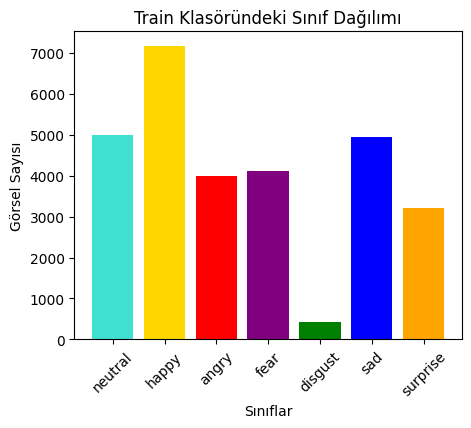

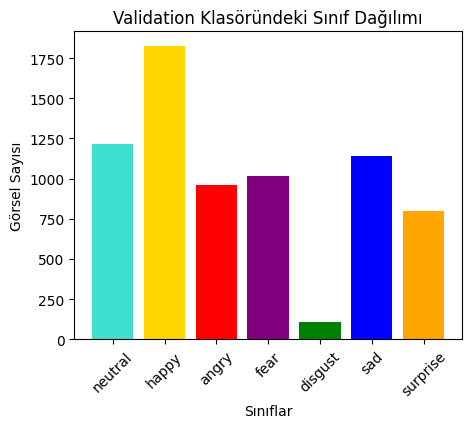

In [9]:
import matplotlib.pyplot as plt

# Train klasöründeki sınıf isimleri ve sınıflardaki görsel sayıları
class_names = ['neutral', 'happy', 'angry', 'fear', 'disgust', 'sad', 'surprise']
class_counts = [4982, 7164, 3993, 4103, 436, 4938, 3205]

colors = ['turquoise', 'gold', 'red', 'purple', 'green', 'blue', 'orange']

plt.figure(figsize=(5, 4))
plt.bar(class_names, class_counts, color=colors)
plt.xlabel('Sınıflar')
plt.ylabel('Görsel Sayısı')
plt.title('Train Klasöründeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()

# Validation klasöründeki sınıf isimleri ve sınıflardaki görsel sayıları
class_names = ['neutral', 'happy', 'angry', 'fear', 'disgust', 'sad', 'surprise']
class_counts = [1216, 1825, 960, 1018, 111, 1139, 797]

colors = ['turquoise', 'gold', 'red', 'purple', 'green', 'blue', 'orange']

plt.figure(figsize=(5, 4))
plt.bar(class_names, class_counts, color=colors)
plt.xlabel('Sınıflar')
plt.ylabel('Görsel Sayısı')
plt.title('Validation Klasöründeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()

Eğitim veri setimizdeki görüntü ifadeleri, 'disgust' kategorisi dışında oldukça dengelidir.

**'Train' veri setinden 'Test' veri setinin oluşturulması**

In [10]:
import os
import random
import shutil

def create_test_set_from_train(train_dir, test_dir, test_size=0.2):
    # Creating the test folder
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    # Creating test data set from Train folder
    train_sub_classes = [sub_class for sub_class in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, sub_class))]

    for sub_class in train_sub_classes:
        sub_class_dir = os.path.join(train_dir, sub_class)
        images = os.listdir(sub_class_dir)
        random.shuffle(images)

        # Number of images to be allocated to the test dataset
        num_test_images = int(len(images) * test_size)
        test_images = images[:num_test_images]

        # Creating new test subfolder
        test_sub_class_dir = os.path.join(test_dir, sub_class)
        if not os.path.exists(test_sub_class_dir):
            os.makedirs(test_sub_class_dir)

        # Move images to test folder
        for image in test_images:
            src = os.path.join(sub_class_dir, image)
            dst = os.path.join(test_sub_class_dir, image)
            shutil.move(src, dst)


train_dir = '/content/images/images/train'
test_dir = '/content/images/images/test'
create_test_set_from_train(train_dir, test_dir, test_size=0.2)

# Print the number of images in Train and Test folders
def count_images_in_dir(directory):
    total_images = 0
    sub_classes = [sub_class for sub_class in os.listdir(directory) if os.path.isdir(os.path.join(directory, sub_class))]
    for sub_class in sub_classes:
        sub_class_dir = os.path.join(directory, sub_class)
        total_images += len(os.listdir(sub_class_dir))
    return total_images

num_train_images = count_images_in_dir(train_dir)
num_test_images = count_images_in_dir(test_dir)

print(f"Number of images in the Train folder after splitting: {num_train_images}")
print(f"Number of images in the Test folder: {num_test_images}")


Number of images in the Train folder after splitting: 23060
Number of images in the Test folder: 5761


**Oluşturulan 'Test' veri kümesindeki veri dağılımı**

Test Folder
* fear - 820
* disgust - 87
* surprise - 641
* happy - 1432
* angry - 798
* sad - 987
* neutral - 996


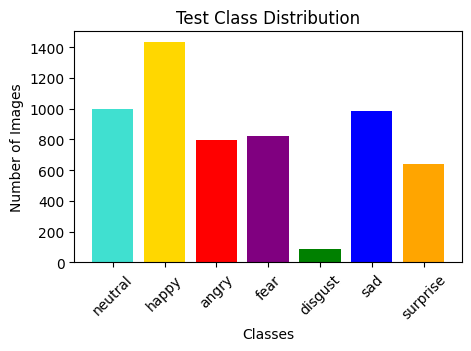

In [11]:
data_dir = '/content/images/images/test'
image_counts = count_images_in_directory(data_dir)
print("Test Folder")
# Print names and image counts of subfolders
for folder, count in image_counts.items():
    print(f"* {folder} - {count}")

# Class names and number of images in the class test folder
class_names = ['neutral', 'happy', 'angry', 'fear', 'disgust', 'sad', 'surprise']
class_counts = [996, 1432, 798, 820, 87, 987, 641]

colors = ['turquoise', 'gold', 'red', 'purple', 'green', 'blue', 'orange']

plt.figure(figsize=(5, 3))
plt.bar(class_names, class_counts, color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Test Class Distribution')
plt.xticks(rotation=45)
plt.show()


**Görüntülerin hepsi aynı boyutta mı?**

In [12]:
import os
import cv2

def get_image_sizes(directory):
    image_sizes = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is not None:
                    height, width = image.shape[:2]
                    image_sizes[file] = (width, height)
    return image_sizes

def check_image_sizes(image_sizes):
    unique_sizes = set(image_sizes.values())
    if len(unique_sizes) == 1:
        print(f"Tüm görseller aynı boyutta: {unique_sizes.pop()}")
    else:
        print("Görseller farklı boyutlarda:")
        for file, size in image_sizes.items():
            print(f"{file}: {size}")

train_dir = '/content/images/images/train'
validation_dir = '/content/images/images/validation'
test_dir = '/content/images/images/test'

train_image_sizes = get_image_sizes(train_dir)
validation_image_sizes = get_image_sizes(validation_dir)
test_image_sizes = get_image_sizes(test_dir)

print("Train setindeki görüntü boyutları:")
check_image_sizes(train_image_sizes)

print("\nValidation setindeki görüntü boyutları:")
check_image_sizes(validation_image_sizes)

print("\nTest setindeki görüntü boyutları:")
check_image_sizes(test_image_sizes)

Train setindeki görüntü boyutları:
Tüm görseller aynı boyutta: (48, 48)

Validation setindeki görüntü boyutları:
Tüm görseller aynı boyutta: (48, 48)

Test setindeki görüntü boyutları:
Tüm görseller aynı boyutta: (48, 48)


**Örnek görüntü görselleştirilmesi**<br>
Bu adım, veri kümesinden rastgele bir görüntü seçerek veri kümesi hakkında bilgi edinmemizi sağlar.

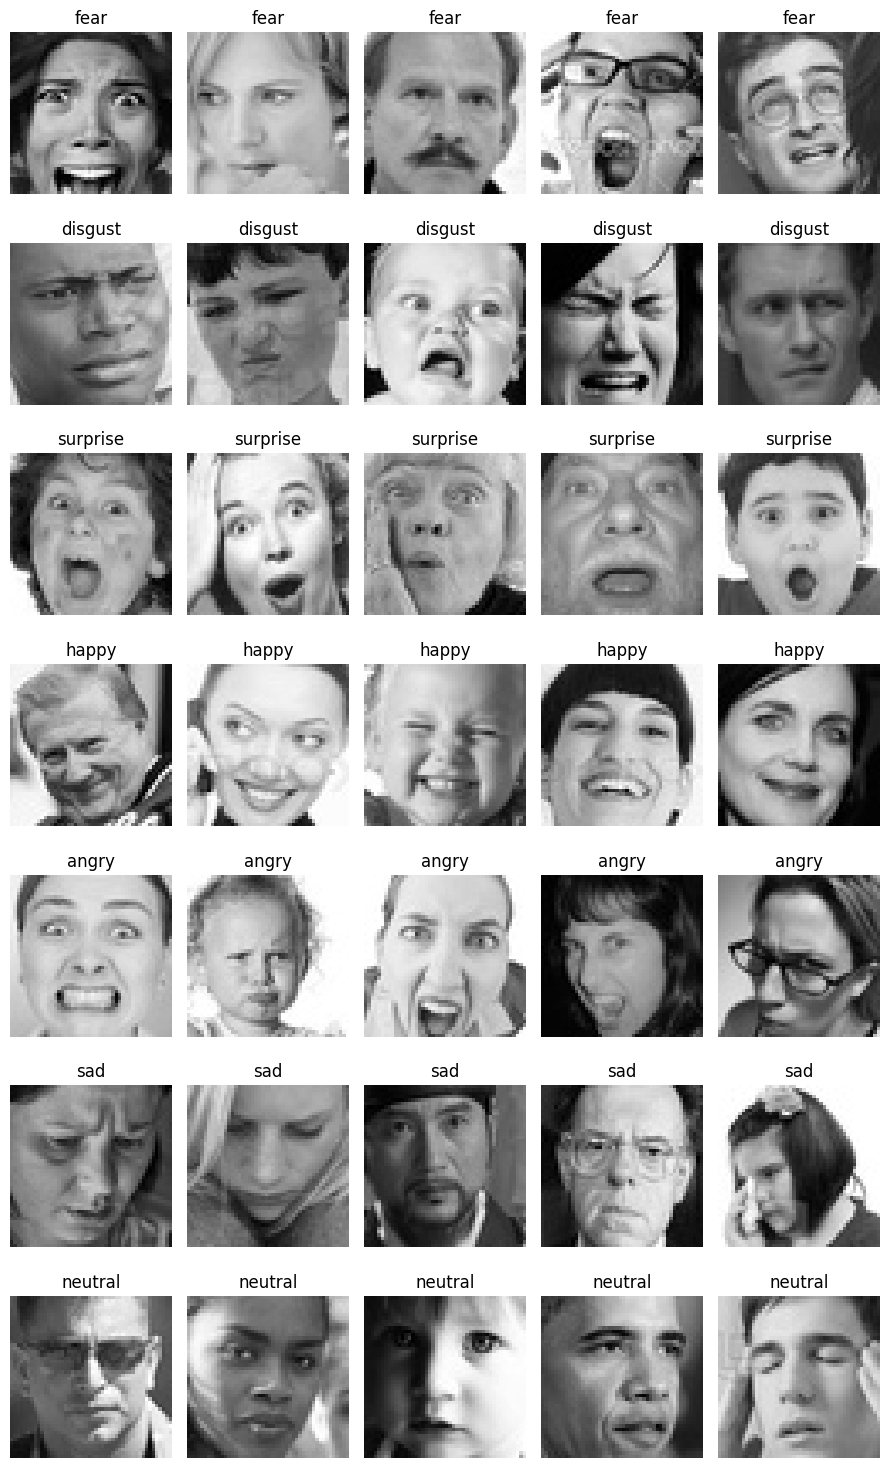

In [13]:
import numpy as np
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

# Görsel boyutu: 48x48 piksel
pic_size = 48

# Görsellerin bulunduğu dizin yolu
base_path = "/content/images/images/"

# Görselleri göstermek için figür ayarla
plt.figure(figsize=(9,15))
cpt = 0

# 'train' dizinindeki tüm ifadeler
for expression in os.listdir(base_path + "train"):
    # Her ifade için 5 görsel göster
    for i in range(5):
        cpt += 1
        plt.subplot(7, 5, cpt)
        # Görseli yükle ve boyutlandır
        img_path = os.path.join(base_path + "train/" + expression, os.listdir(base_path + "train/" + expression)[i])
        img = load_img(img_path, target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")
        plt.title(expression)  # İfade adını başlık olarak ekle
        plt.axis('off')  # Eksenleri kapat

plt.tight_layout()
plt.show()

In [14]:
# Her ifade için eğitim görsel sayısını hesapla

for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " ifadesine ait görüntü")

3283 fear ifadesine ait görüntü
349 disgust ifadesine ait görüntü
2564 surprise ifadesine ait görüntü
5732 happy ifadesine ait görüntü
3195 angry ifadesine ait görüntü
3951 sad ifadesine ait görüntü
3986 neutral ifadesine ait görüntü


Eğitim veri setimizdeki görüntü ifadeleri, 'disgust' kategorisi dışında oldukça dengelidir.

**Eğitim ve Doğrulama Görsellerini Hazırlama**<br>
Eğitim ve doğrulama veri setlerini hazırlamak ve bunları modelin eğitimine uygun hale getirmek için veri jeneratörleri oluşturuyoruz.

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sinir ağına her batch için verilecek görsel sayısı
batch_size = 64

# Eğitim ve doğrulama veri artırıcılarını oluşturma
datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

# Eğitim verilerini hazırlamak için DataGenerator
train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size, pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# Doğrulama verilerini hazırlamak için DataGenerator
validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size, pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 23060 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


**CNN Model Oluşturma**

In [39]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

**Model eğitimi**

In [40]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,  # Use fit instead of fit_generator
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//validation_generator.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.2188 - loss: 2.0772 - val_accuracy: 0.3260 - val_loss: 1.7192
Epoch 2/50
  1/360 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3438 - loss: 1.8106

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.3438 - loss: 1.8106 - val_accuracy: 0.1154 - val_loss: 2.3958
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.3035 - loss: 1.8166 - val_accuracy: 0.3509 - val_loss: 1.6585
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3438 - loss: 1.6555 - val_accuracy: 0.3846 - val_loss: 2.2401
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.3511 - loss: 1.7072 - val_accuracy: 0.3557 - val_loss: 1.7351
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - accuracy: 0.3438 - loss: 1.6282 - val_accuracy: 0.3462 - val_loss: 2.6832
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.3742 - loss: 1.6321 - val_accuracy: 0.4268 - val_loss: 1.5205
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.5836 - val_accuracy: 0.4615 - val_loss: 1.8153
Epoch 9/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.3958 - loss: 1.5666 - val_accuracy: 0.

**Modelin yapısını JSON formatında kaydetme**

In [41]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

**Tam modeli kaydetme**

In [42]:
# Modelinizi kaydetme (hem yapısı hem de ağırlıkları)
model.save("full_model.h5")

Bu kod, modelin yapısını JSON formatında dışa aktarır ve bu yapıyı "model.json" dosyasına kaydeder. Bu, modelin yapısını kaydetmek ve gerektiğinde yüklemek için kullanılır. Modeli yeniden inşa etmek veya paylaşmak için bu JSON dosyası kullanılabilir. Ancak, modelin ağırlıkları ve eğitilmiş durumu bu dosyada saklanmaz; bu bilgilere sahip olmak için ayrı bir işlem gereklidir.

**Sonuçları analiz etme**

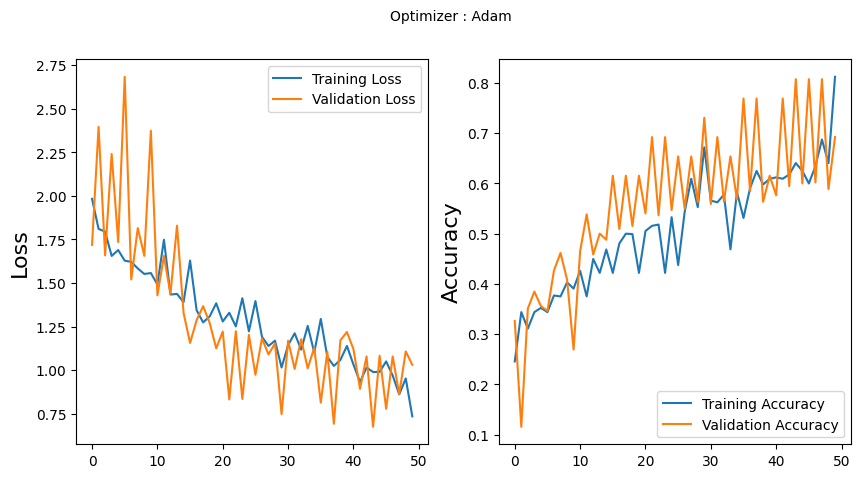

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Grafiklerde, modelin eğitim sürecinde hem kayıp (loss) hem de doğruluk (accuracy) değerlerinde iyileşme gözleniyor. Ancak, doğrulama verisi üzerinde belirgin dalgalanmalar var, bu da modelin doğrulama verisine karşı kararsız performans gösterdiğini ve aşırı öğrenme (overfitting) riski taşıyabileceğini işaret ediyor. Genel olarak, modelin performansı artıyor olsa da, doğrulama verisi üzerinde daha tutarlı sonuçlar elde etmek için düzenlemeler gerekebilir.

**Confusion Matrix**

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


<Figure size 640x480 with 0 Axes>

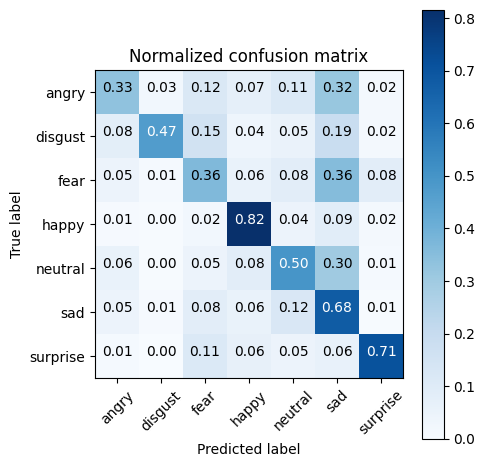

In [46]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Modelimiz mutlu ve şaşkın yüzleri tahmin etmede çok başarılıdır. Ancak korkulan yüzleri üzgün yüzlerle karıştırdığı için oldukça kötü tahmin etmektedir. Daha fazla araştırma ve daha fazla kaynakla bu model kesinlikle geliştirilebilir, ancak bu çalışmanın amacı öncelikle bu alanda yapılanlara kıyasla oldukça iyi bir model elde etmeye odaklanmaktı. Şimdi modelimizi gerçek bir durumda deneme zamanı! Bir web kamerası girdisi ile gerçek zamanlı tahminler gerçekleştirmek için modelimize hizmet etmek üzere flask kullanacağız.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Actual Class: neutral
Predicted Class: sad


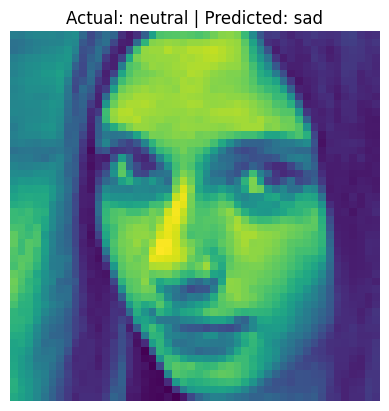

In [49]:
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Define validation directory and classes
validation_dir = '/content/images/images/validation'
class_labels = list(validation_generator.class_indices.keys())

#Choose a random class and a random image within that class
random_class = random.choice(class_labels)
class_dir = os.path.join(validation_dir, random_class)
random_image = random.choice(os.listdir(class_dir))

#Load and preprocess the image
img_path = os.path.join(class_dir, random_image)
img = load_img(img_path, target_size=(48, 48), color_mode='grayscale') # Load image as grayscale
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
#Predict the class of the image
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = class_labels[predicted_class_index]

#Get the actual class label
actual_class = random_class
import matplotlib.pyplot as plt

#Print the actual and predicted values
print(f'Actual Class: {actual_class}')
print(f'Predicted Class: {predicted_class}')

#Display the image
plt.imshow(img)
plt.title(f'Actual: {actual_class} | Predicted: {predicted_class}')
plt.axis('off')
plt.show()

Model yüklendi.
Found 5761 images belonging to 7 classes.
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


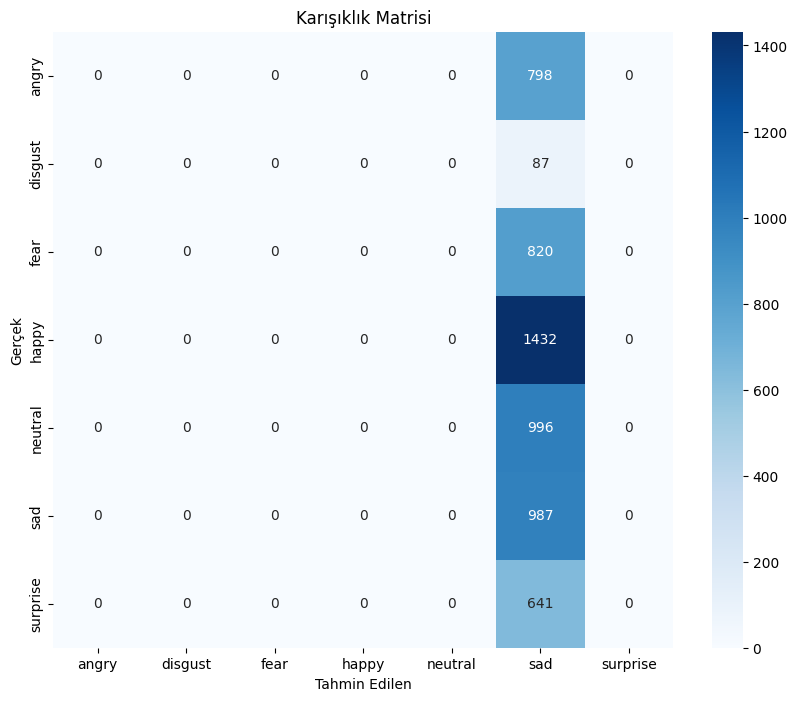

Sınıflandırma Raporu:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       798
     disgust       0.00      0.00      0.00        87
        fear       0.00      0.00      0.00       820
       happy       0.00      0.00      0.00      1432
     neutral       0.00      0.00      0.00       996
         sad       0.17      1.00      0.29       987
    surprise       0.00      0.00      0.00       641

    accuracy                           0.17      5761
   macro avg       0.02      0.14      0.04      5761
weighted avg       0.03      0.17      0.05      5761



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Modeli yükleyin
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

# Model ağırlıklarını yükleyin
model.load_weights("/content/full_model.h5")
print("Model yüklendi.")

# Test verilerini yükleyin
test_dir = '/content/images/images/test'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Tüm test verisini yüklemek için
X_test = []
y_test = []

for i in range(len(test_generator)):
    X, y = test_generator[i]
    X_test.extend(X)
    y_test.extend(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Tahmin yapın
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Karışıklık matrisini hesaplayın
cm = confusion_matrix(y_true, y_pred_classes)

# Karışıklık matrisini görselleştirin
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()

# Sınıflandırma raporunu yazdırın
print("Sınıflandırma Raporu:\n", classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

In [48]:
# Model will predict the probability values for 7 labels for a test image
score = model.predict(X_test)
print (model.summary())

new_X = [ np.argmax(item) for item in score ]
y_test2 = [ np.argmax(item) for item in y_test]

# Calculating categorical accuracy taking label having highest probability
accuracy = [ (x==y) for x,y in zip(new_X,y_test2) ]
print(" Accuracy on Test set : " , np.mean(accuracy))

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,428,247 (51.22 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 8,949,520 (34.14 MB)

None
 Accuracy on Test set :  0.17132442284325639
